In [62]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
import keras
from keras.layers import *
from keras.models import Model,Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image

In [63]:
emotion_labels=["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

In [64]:
num_classes=len(emotion_labels)

In [65]:
fer_data=h5py.File('./data.h5','r',driver='core')

In [66]:
fer_x=np.asarray(fer_data['Training_pixel']).reshape(28709,48,48,1)

In [67]:
fer_y=fer_data['Training_label']

In [68]:
X_train=fer_x

In [70]:
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48,48,1))

In [71]:
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48,48,1))

In [72]:
num_train=X_train.shape[0]

In [73]:
num_val_public=X_test_public.shape[0]

In [74]:
num_val_private=X_test_private.shape[0]

In [75]:
print('Training:',X_train.shape)

Training: (28709, 48, 48, 1)


In [76]:
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 48, 48, 1)


In [77]:
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 48, 48, 1)


In [78]:
Y_train=fer_data['Training_label']

In [79]:
Y_train=to_categorical(Y_train,num_classes)

In [80]:
Y_test_public=fer_data['PublicTest_label']

In [81]:
Y_test_private=fer_data['PrivateTest_label']

In [82]:
Y_test_public=to_categorical(Y_test_public,num_classes)

In [83]:
Y_test_private=to_categorical(Y_test_private,num_classes)

In [84]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [85]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [86]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [88]:
def get_nn_model():
    model=Sequential()
    
    model.add(Flatten(input_shape=(48,48,1)))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [89]:
from keras.layers import Convolution2D,Activation,BatchNormalization,MaxPooling2D,Dropout,Dense,Flatten,AveragePooling2D

In [90]:
from keras.models import Sequential

In [91]:
def get_cnn_model():
    model=Sequential()
    
    model.add(Convolution2D(64,(3,1),padding='same',input_shape=(48,48,1)))
    model.add(Convolution2D(64,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(128,(3,1),padding='same'))
    model.add(Convolution2D(128,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(256,(3,1),padding='same'))
    model.add(Convolution2D(256,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(512,(3,1),padding='same'))
    model.add(Convolution2D(512,(1,3),padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2),strides=None,padding='same'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [92]:
cnn_model=get_cnn_model()

In [93]:
nn_model=get_nn_model()

In [94]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 64)        12352     
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 128)       24704     
__________

In [95]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1180160   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
__________

In [96]:
from keras.preprocessing.image import ImageDataGenerator

In [97]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [98]:
from keras import backend as K

In [99]:
#def fbeta(y_true,y_pred,threshold_shift=0):
#    beta=1
    
#    y_pred=K.clip(y_pred,0,1)
    
#    y_pred_bin=K.round(y_pred+threshold_shift)
    
#    tp=K.sum(K.round(y_true*y_pred_bin),axis=1)+K.epsilon())
#    fp=K.sum(K.round(K.clip(y_pred_bin-y_true,0,1)),axis=1)
#    fn=K.sum(K.round(K.clip(y_true-y_pred,0,1)),axis=1)
    
#    precision=tp/(tp+fp)
#    recall=tp/(tp+fn)
    
#    beta_squard=beta**2
#    return K.mean((beta_squard+1)*(precision*recall)/(beta_squard*precision+recall+K.epsilon()))
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 1

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin), axis=1) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)), axis=1)
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return K.mean((beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon()))

In [102]:
def train_model(model):
    filepath='../opt/fer-cnn/Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,mode='auto')
    reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=0,mode='auto',cooldown=0,min_lr=0)
    early_stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto')
    datagen=ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=False,
    )
    
    datagen.fit(X_train)
    datagen.fit(X_test)
    batch_size=32
    
    num_epochs=25
    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                 metrics=[fbeta,'acc'])
    train_flow=datagen.flow(X_train,Y_train,batch_size=batch_size)
    test_flow_public=datagen.flow(X_test_public,Y_test_public)
    test_flow_private=datagen.flow(X_test_private,Y_test_private)
    #history=cnn_model.fit_generator(train_flow,
     #                              step_per_epoch=len(X_train)/batch_size,
     #                              epochs=num_epochs,
     #                              verbose=1,
     #                              test_data=test_flow,
     #                              test_steps=len(X_test)/batch_size,
     #                              callbacks=[checkpointer,reduce_lr,checkpointer])
    history_public = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_public, 
                    validation_steps=len(X_test_public) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    history_private = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_private, 
                    validation_steps=len(X_test_private) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history_public,history_private,model

In [103]:
history_public,history_private,cnn_model = train_model(cnn_model)

Epoch 1/25
898/897 [==============================] - 17s 18ms/step - loss: 0.5709 - fbeta: 0.7384 - acc: 0.7906 - val_loss: 1.1132 - val_fbeta: 0.5926 - val_acc: 0.6473

Epoch 00001: saving model to ../opt/fer-cnn/Model.01-0.6473.hdf5

Epoch 00001: saving model to ../opt/fer-cnn/Model.01-0.6473.hdf5
Epoch 2/25
898/897 [==============================] - 15s 16ms/step - loss: 0.5818 - fbeta: 0.7295 - acc: 0.7848 - val_loss: 1.0742 - val_fbeta: 0.5706 - val_acc: 0.6397

Epoch 00002: saving model to ../opt/fer-cnn/Model.02-0.6397.hdf5

Epoch 00002: saving model to ../opt/fer-cnn/Model.02-0.6397.hdf5
Epoch 3/25
898/897 [==============================] - 15s 16ms/step - loss: 0.5674 - fbeta: 0.7354 - acc: 0.7908 - val_loss: 1.0934 - val_fbeta: 0.5982 - val_acc: 0.6500

Epoch 00003: saving model to ../opt/fer-cnn/Model.03-0.6500.hdf5

Epoch 00003: saving model to ../opt/fer-cnn/Model.03-0.6500.hdf5
Epoch 4/25
898/897 [==============================] - 15s 16ms/step - loss: 0.5724 - fbeta: 0.

898/897 [==============================] - 15s 16ms/step - loss: 0.3395 - fbeta: 0.8519 - acc: 0.8787 - val_loss: 1.0957 - val_fbeta: 0.6314 - val_acc: 0.6690

Epoch 00003: saving model to ../opt/fer-cnn/Model.03-0.6690.hdf5

Epoch 00003: saving model to ../opt/fer-cnn/Model.03-0.6690.hdf5
Epoch 4/25
898/897 [==============================] - 15s 16ms/step - loss: 0.3325 - fbeta: 0.8542 - acc: 0.8800 - val_loss: 1.0927 - val_fbeta: 0.6333 - val_acc: 0.6670

Epoch 00004: saving model to ../opt/fer-cnn/Model.04-0.6670.hdf5

Epoch 00004: saving model to ../opt/fer-cnn/Model.04-0.6670.hdf5
Epoch 5/25
898/897 [==============================] - 15s 17ms/step - loss: 0.3321 - fbeta: 0.8583 - acc: 0.8843 - val_loss: 1.0820 - val_fbeta: 0.6353 - val_acc: 0.6684

Epoch 00005: saving model to ../opt/fer-cnn/Model.05-0.6684.hdf5

Epoch 00005: saving model to ../opt/fer-cnn/Model.05-0.6684.hdf5
Epoch 6/25
898/897 [==============================] - 15s 16ms/step - loss: 0.3265 - fbeta: 0.8542 - acc:

In [104]:
def eval_model_public(history,model):
    batch_size=32
    score=model.evaluate(X_test_public,Y_test_public,steps=(int)(len(X_test_public)/batch_size))
    print('Evaluation loss:',score[0])
    print('Evaluation accuracy:',score[1])
                        
    plt.plot(history.history['acc'],color='b',label='Training')
    plt.plot(history.history['val_acc'],color='g',label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()
                         
    plt.plot(history.history['loss'],color='b',label='Training')
    plt.plot(history.history['val_loss'],color='g',label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
                         
    y_pred=model.predict_classes(X_test_public)
    y_true=np.asarray([np.argmax(i) for i in Y_test_public])
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm=confusion_matrix(y_true,y_pred)
    cm_normalised=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(cm_normalised,
                  annot=True,
                  linewidths=0,
                  square=False,
                  cmap="Greens",
                  yticklabels=emotion_labels,
                  xticklabels=emotion_labels,
                  vmin=0,
                  vmax=np.max(cm_normalised),
                  fmt=".2f",
                  annot_kws={"size":20})
    ax.set(xlabel='Predicted label',ylabel='True label')
    

In [105]:
def eval_model_private(history,model):
    batch_size=32
    score=model.evaluate(X_test_private,Y_test_private,steps=(int)(len(X_test_private)/batch_size))
    print('Evaluation loss:',score[0])
    print('Evaluation accuracy:',score[1])
                        
    plt.plot(history.history['acc'],color='b',label='Training')
    plt.plot(history.history['val_acc'],color='g',label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()
                         
    plt.plot(history.history['loss'],color='b',label='Training')
    plt.plot(history.history['val_loss'],color='g',label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
                         
    y_pred=model.predict_classes(X_test_private)
    y_true=np.asarray([np.argmax(i) for i in Y_test_private])
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm=confusion_matrix(y_true,y_pred)
    cm_normalised=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(figsize=(10,10))
    ax=sns.heatmap(cm_normalised,
                  annot=True,
                  linewidths=0,
                  square=False,
                  cmap="Greens",
                  yticklabels=emotion_labels,
                  xticklabels=emotion_labels,
                  vmin=0,
                  vmax=np.max(cm_normalised),
                  fmt=".2f",
                  annot_kws={"size":20})
    ax.set(xlabel='Predicted label',ylabel='True label')

112/112 [==============================] - 34s 304ms/step
Evaluation loss: 1.2039707899093628
Evaluation accuracy: 0.6241292953491211


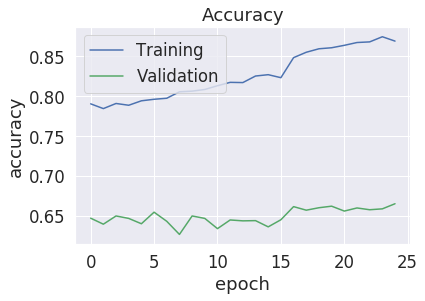

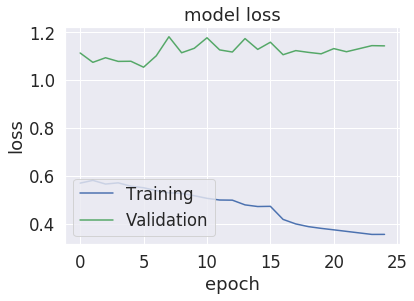

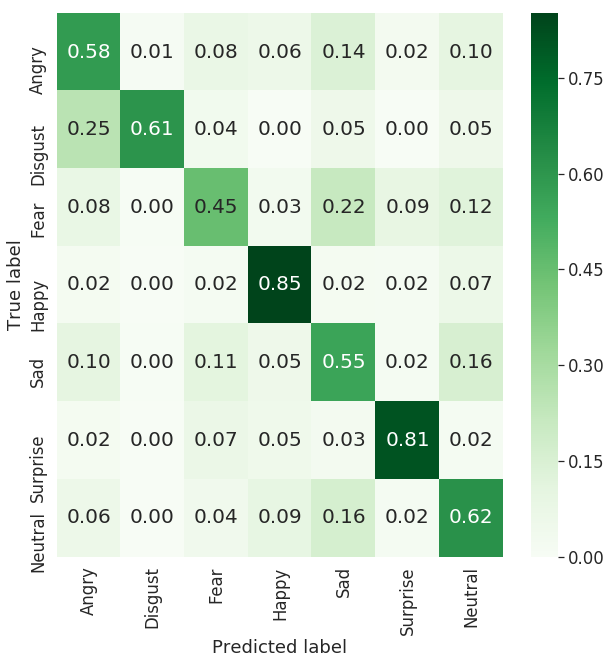

In [106]:
eval_model_public(history_public, cnn_model)

112/112 [==============================] - 34s 306ms/step
Evaluation loss: 1.1233980655670166
Evaluation accuracy: 0.6336026787757874


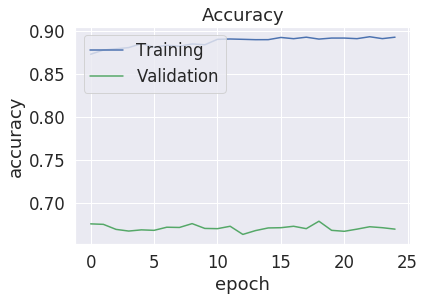

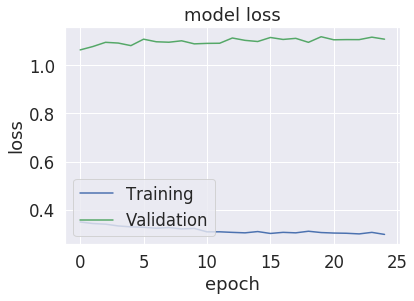

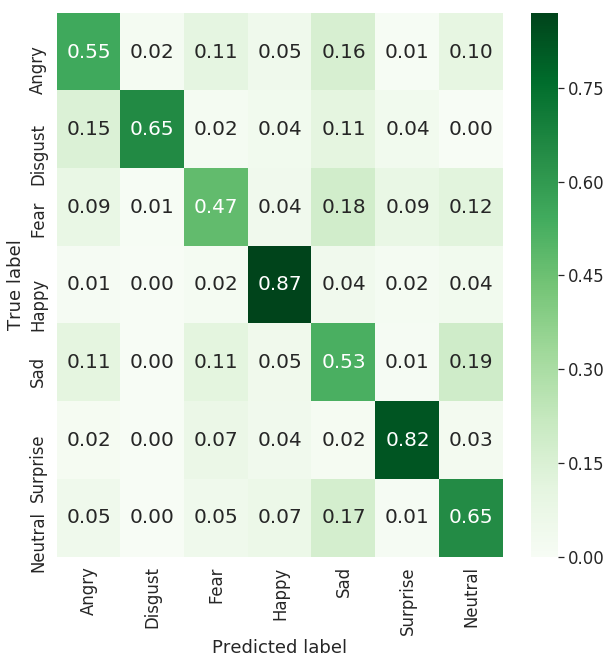

In [107]:
eval_model_private(history_private, cnn_model)

In [109]:
def train_nn_model(model):
    filepath='../opt/fer-cnn/nn-Model.{epoch:02d}-{val_acc:.4f}.hdf5'
    checkpointer=ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,mode='auto')
    reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10,verbose=0,mode='auto',cooldown=0,min_lr=0)
    early_stop=EarlyStopping(monitor='val_loss',min_delta=0,patience=0,verbose=0,mode='auto')
    datagen=ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=False,
    )
    
    datagen.fit(X_train)
    datagen.fit(X_test)
    batch_size=32
    
    num_epochs=25
    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                 metrics=[fbeta,'acc'])
    train_flow=datagen.flow(X_train,Y_train,batch_size=batch_size)
    test_flow_public=datagen.flow(X_test_public,Y_test_public)
    test_flow_private=datagen.flow(X_test_private,Y_test_private)
    #history=cnn_model.fit_generator(train_flow,
     #                              step_per_epoch=len(X_train)/batch_size,
     #                              epochs=num_epochs,
     #                              verbose=1,
     #                              test_data=test_flow,
     #                              test_steps=len(X_test)/batch_size,
     #                              callbacks=[checkpointer,reduce_lr,checkpointer])
    history_public = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_public, 
                    validation_steps=len(X_test_public) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    history_private = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs, 
                    verbose=1, 
                    validation_data=test_flow_private, 
                    validation_steps=len(X_test_private) / batch_size,
                    callbacks=[checkpointer, reduce_lr, checkpointer])
    return history_public,history_private,model

In [110]:
nn_history_public,nn_history_private, nn_model = train_nn_model(nn_model)

Epoch 1/25
898/897 [==============================] - 6s 7ms/step - loss: 1.7805 - fbeta: 0.0813 - acc: 0.3054 - val_loss: 1.7286 - val_fbeta: 0.1117 - val_acc: 0.3096

Epoch 00001: saving model to ../opt/fer-cnn/nn-Model.01-0.3096.hdf5

Epoch 00001: saving model to ../opt/fer-cnn/nn-Model.01-0.3096.hdf5
Epoch 2/25
898/897 [==============================] - 5s 6ms/step - loss: 1.6459 - fbeta: 0.1049 - acc: 0.3521 - val_loss: 1.6822 - val_fbeta: 0.0772 - val_acc: 0.3246

Epoch 00002: saving model to ../opt/fer-cnn/nn-Model.02-0.3246.hdf5

Epoch 00002: saving model to ../opt/fer-cnn/nn-Model.02-0.3246.hdf5
Epoch 3/25
898/897 [==============================] - 5s 5ms/step - loss: 1.5948 - fbeta: 0.1171 - acc: 0.3746 - val_loss: 1.6384 - val_fbeta: 0.0365 - val_acc: 0.3658

Epoch 00003: saving model to ../opt/fer-cnn/nn-Model.03-0.3658.hdf5

Epoch 00003: saving model to ../opt/fer-cnn/nn-Model.03-0.3658.hdf5
Epoch 4/25
898/897 [==============================] - 5s 6ms/step - loss: 1.5616 -

898/897 [==============================] - 5s 6ms/step - loss: 1.2546 - fbeta: 0.3098 - acc: 0.5185 - val_loss: 1.5040 - val_fbeta: 0.1870 - val_acc: 0.4118

Epoch 00003: saving model to ../opt/fer-cnn/nn-Model.03-0.4118.hdf5

Epoch 00003: saving model to ../opt/fer-cnn/nn-Model.03-0.4118.hdf5
Epoch 4/25
898/897 [==============================] - 5s 6ms/step - loss: 1.2450 - fbeta: 0.3180 - acc: 0.5239 - val_loss: 1.5533 - val_fbeta: 0.2402 - val_acc: 0.4191

Epoch 00004: saving model to ../opt/fer-cnn/nn-Model.04-0.4191.hdf5

Epoch 00004: saving model to ../opt/fer-cnn/nn-Model.04-0.4191.hdf5
Epoch 5/25
898/897 [==============================] - 5s 6ms/step - loss: 1.2312 - fbeta: 0.3202 - acc: 0.5274 - val_loss: 1.5321 - val_fbeta: 0.2031 - val_acc: 0.4113

Epoch 00005: saving model to ../opt/fer-cnn/nn-Model.05-0.4113.hdf5

Epoch 00005: saving model to ../opt/fer-cnn/nn-Model.05-0.4113.hdf5
Epoch 6/25
898/897 [==============================] - 5s 6ms/step - loss: 1.2210 - fbeta: 0.3

112/112 [==============================] - 2s 19ms/step
Evaluation loss: 1.4237805604934692
Evaluation accuracy: 0.3385344445705414


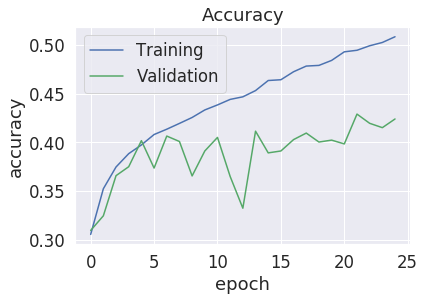

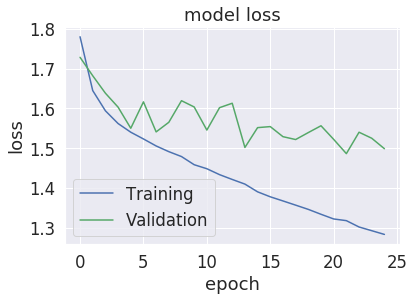

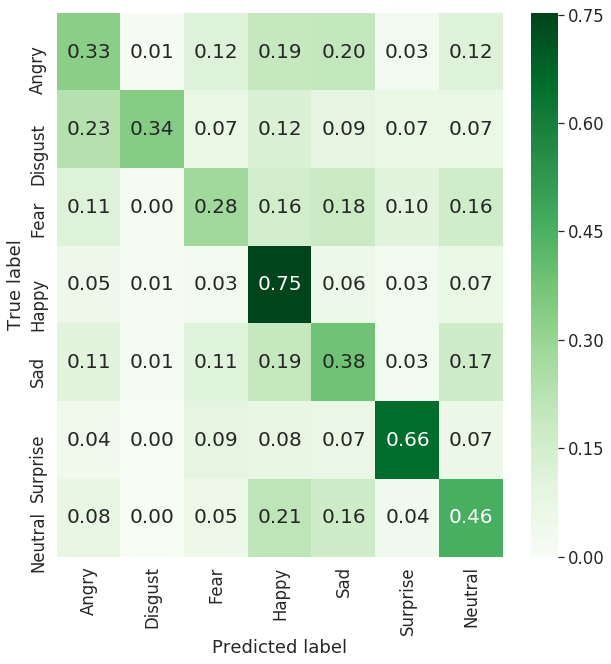

In [111]:
eval_model_public(nn_history_public, nn_model)

112/112 [==============================] - 2s 19ms/step
Evaluation loss: 1.3869919776916504
Evaluation accuracy: 0.34159940481185913


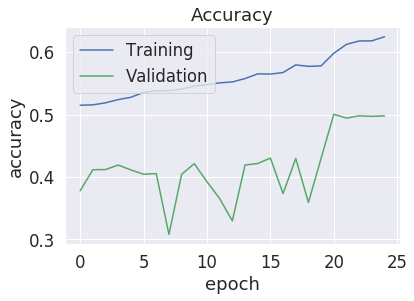

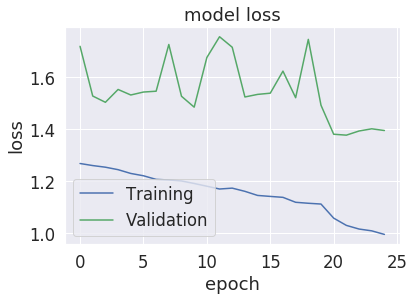

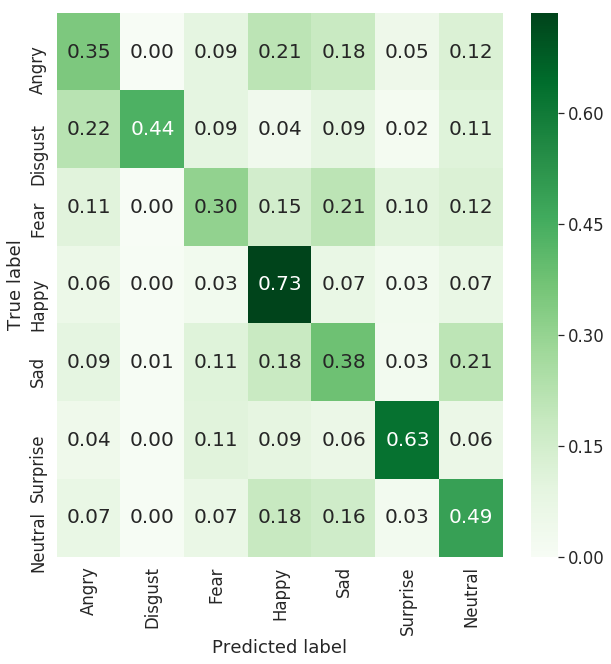

In [112]:
eval_model_private(nn_history_private, nn_model)